In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
COLORS = sns.color_palette('colorblind')

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {
        k: v.replace('localhost', 'api') 
        for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
def get_result_by_exp_id(exp_id: str):
    df_grid_melt = df.melt(
        id_vars=['exp_id'], var_name="metrics", value_name="scores")
    
    # filter by experiment id
    df_grid_melt = df_grid_melt.loc[
        (df_grid_melt['exp_id'] == exp_id) &
        (df_grid_melt['metrics'].str.contains('mean_test_'))]
    
    # rename metric names 
    mapper = {
        'mean_test_f1': 'F-Score', 
        'mean_test_geometric_mean_score': 'G-Mean',
        'mean_test_precision': 'Precision', 
        'mean_test_recall': 'Recall', 
        'mean_test_roc_auc': 'ROC AUC',
        'mean_test_specificity': 'Specificity'}
    df_grid_melt['metrics'] = df_grid_melt['metrics'].apply(
        lambda string: mapper[string])

    # create summary table and save as csv file locally
    dff = pd.DataFrame()
    dff['min'] = df_grid_melt[['scores', 'metrics']].groupby('metrics').min()
    dff['median'] = df_grid_melt[['scores', 'metrics']].groupby('metrics').median()
    dff['mean'] = df_grid_melt[['scores', 'metrics']].groupby('metrics').mean()
    dff['std'] = df_grid_melt[['scores', 'metrics']].groupby('metrics').std()
    dff['max'] = df_grid_melt[['scores', 'metrics']].groupby('metrics').max()
    res_method, model, _ = exp_id.replace(' ', '').split('+')
    dff.to_csv(f'../../data/tables/{res_method}_{model}_metric_scores.csv')

    # plot overall metric performance
    _ = plt.figure(figsize=[8,6])
    sns.barplot(
        data=df_grid_melt, x='metrics', y='scores',
#         showmeans=True,
#         meanprops={
#             'marker':'.',
#             'markerfacecolor':'white', 
#             'markeredgecolor':'black',
#             'markersize':'10'}
    )
    plt.title('Metricas de Rendimiento de "{0}"'.format(exp_id))
    plt.xlabel('metrica')
    plt.ylabel('puntuación')
    plt.tight_layout()
    
    
def get_param_variation_by_exp_id(exp_id: str, param: str):
    # filter df by experiment id and param to plot
    metrics = [
        col for col in df.columns 
        if col.startswith('mean_test_') \
        or col.startswith('mean_train_')]
    mask = ~(df[param].isnull()) & (df['exp_id'] == exp_id)
    cols = ['exp_id', param] + metrics
    df_to_plot = df.loc[mask, cols]
    
    # get pretty titles for plots
    pretty_param = param.split('__')[1]
    titles = [
        'F-Score', 'G-Mean', 'Precision', 
        'Recall', 'ROC AUC', 'Specificity']

    # get list of metrics to plot
    metrics_to_plot = [
        col.replace('mean_test_', '') 
        for col in df.columns 
        if col.startswith('mean_test_')]

    # plot metric score variation in relation with a param change by experiment
    _ = plt.figure(figsize=[10,12])
    plt.suptitle(f'Variación de "{pretty_param}"', fontsize=14)
    for index, metric in enumerate(metrics_to_plot):
        plt.subplot(3,2,index+1)
        sns.lineplot(
            data=df_to_plot,
            x=param,
            y=f'mean_test_{metric}',
            label=f'test',
            color=COLORS[0])
        sns.lineplot(
            data=df_to_plot,
            x=param,
            y=f'mean_train_{metric}',
            label=f'train',
            color=COLORS[1])
        plt.legend(loc='best', frameon=True).get_frame().set_color('white')
        plt.title(titles[index], fontsize=14)
        plt.xlabel(pretty_param)
        plt.ylabel('puntuación')
        plt.tight_layout()

In [4]:
raw_grid_data = requests.get(
    directory['result']['get_grid_cv_results_model_data']).json()

df = pd.DataFrame()
for record in raw_grid_data['result']:
    grid_record = record['message']['data']
    df_grid = pd.DataFrame(grid_record)
    df = pd.concat([df, df_grid], ignore_index=True)

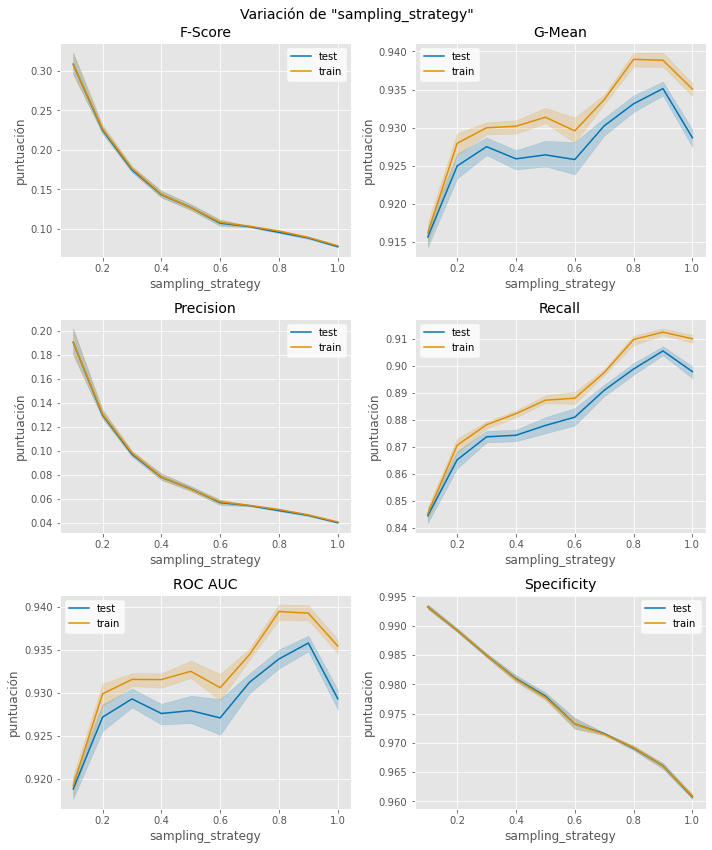

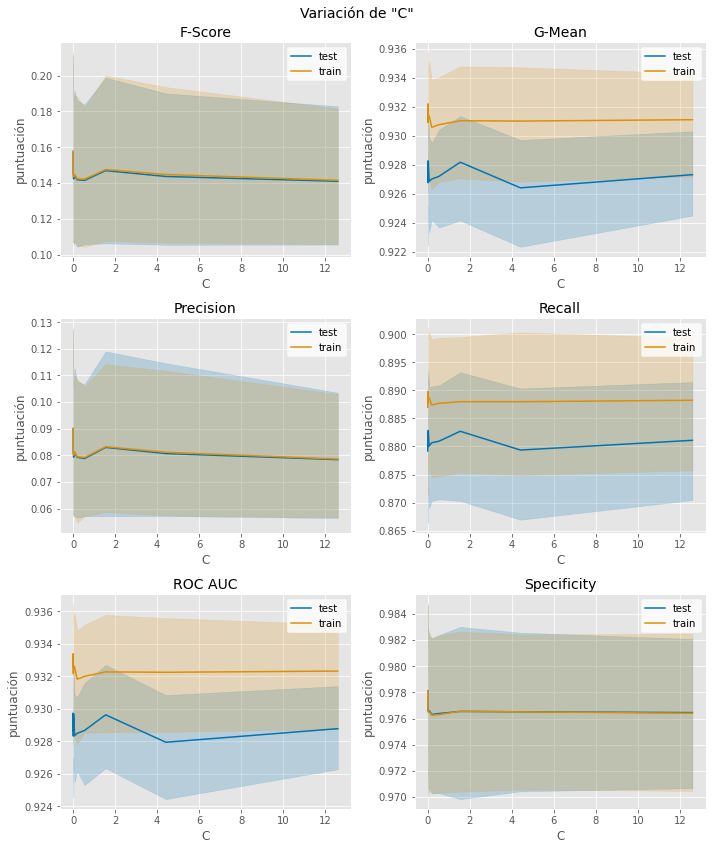

In [5]:
# ROS + LR + GSCV
get_param_variation_by_exp_id(
    'ROS + LR + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'ROS + LR + GSCV', 'param_estimator__C')

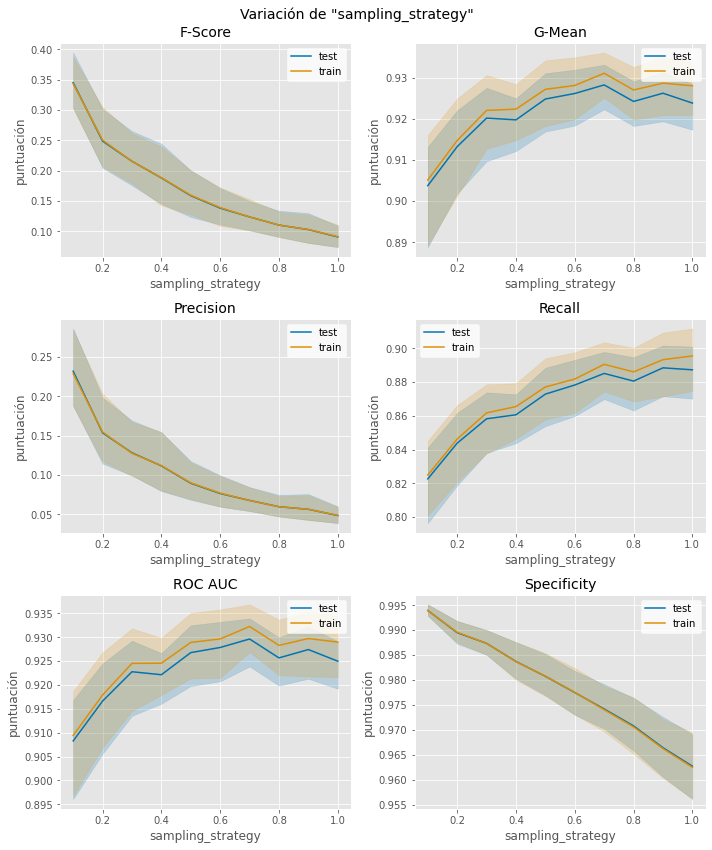

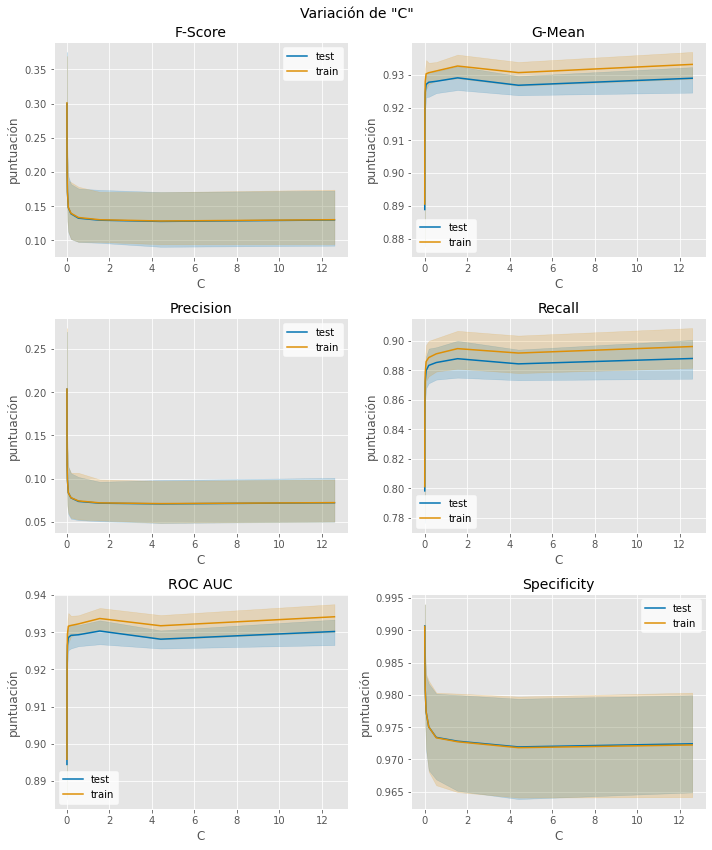

In [6]:
## RUS+LR+GSCV
get_param_variation_by_exp_id(
    'RUS + LR + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'RUS + LR + GSCV', 'param_estimator__C')

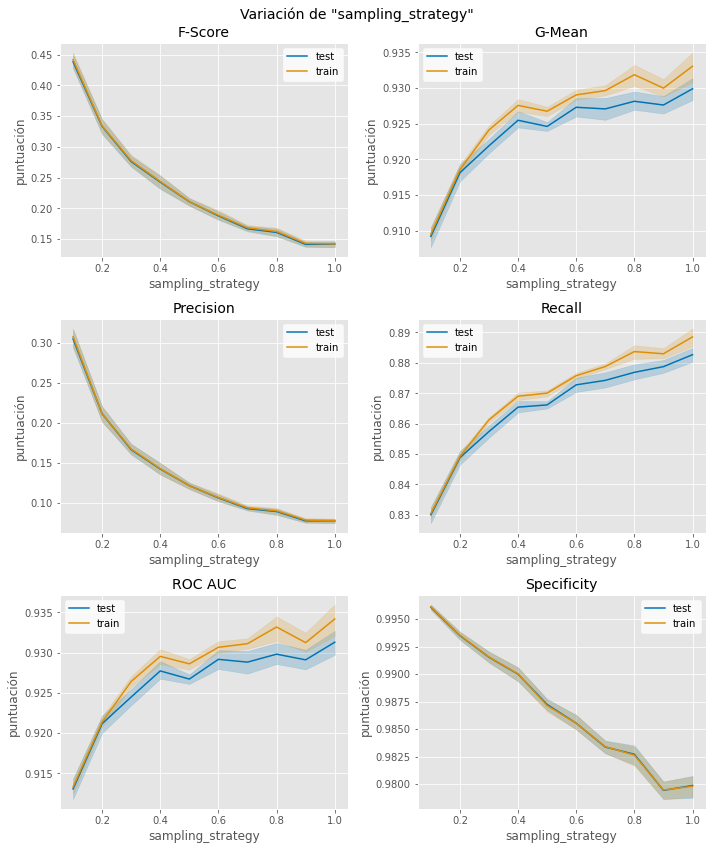

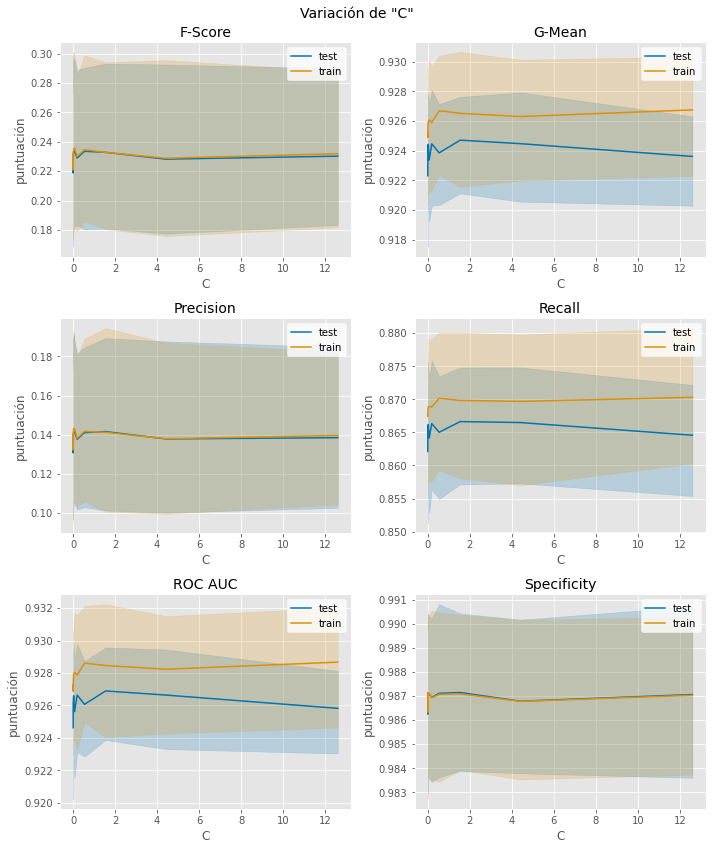

In [7]:
## SMOTE+LR+GSCV
get_param_variation_by_exp_id(
    'SMOTE + LR + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'SMOTE + LR + GSCV', 'param_estimator__C')

In [8]:
## None+RanFor+GSCV


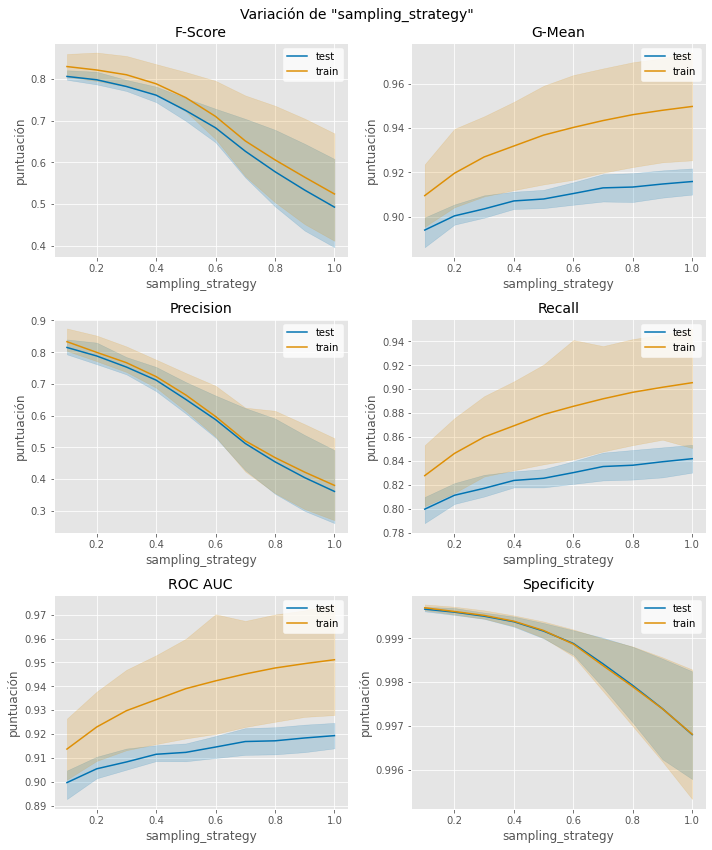

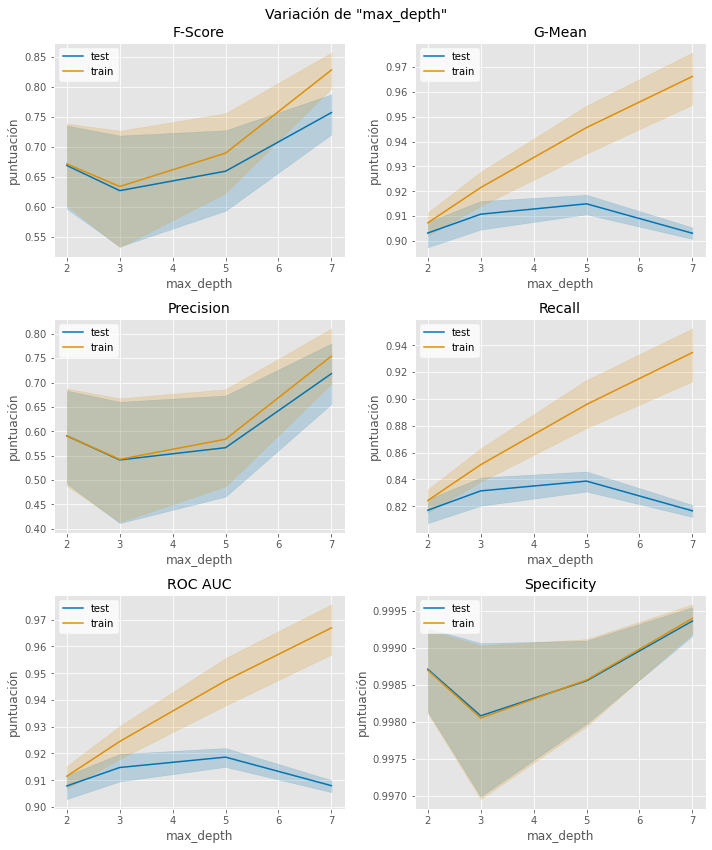

In [9]:
## ROS+RFC+GSCV
get_param_variation_by_exp_id(
    'ROS + RFC + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'ROS + RFC + GSCV', 'param_estimator__max_depth')

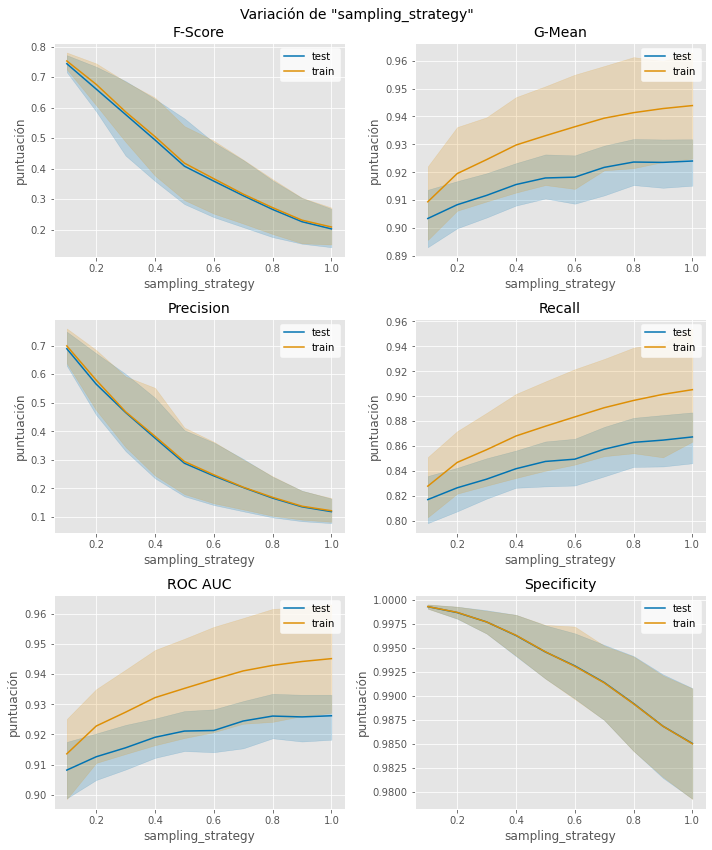

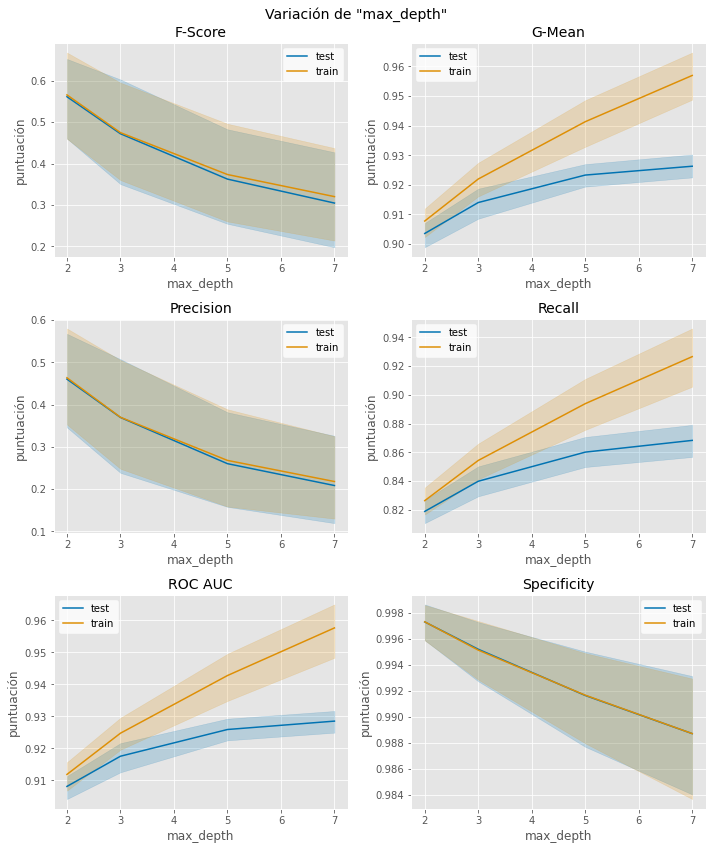

In [10]:
## RUS+RFC+GSCV
get_param_variation_by_exp_id(
    'RUS + RFC + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'RUS + RFC + GSCV', 'param_estimator__max_depth')

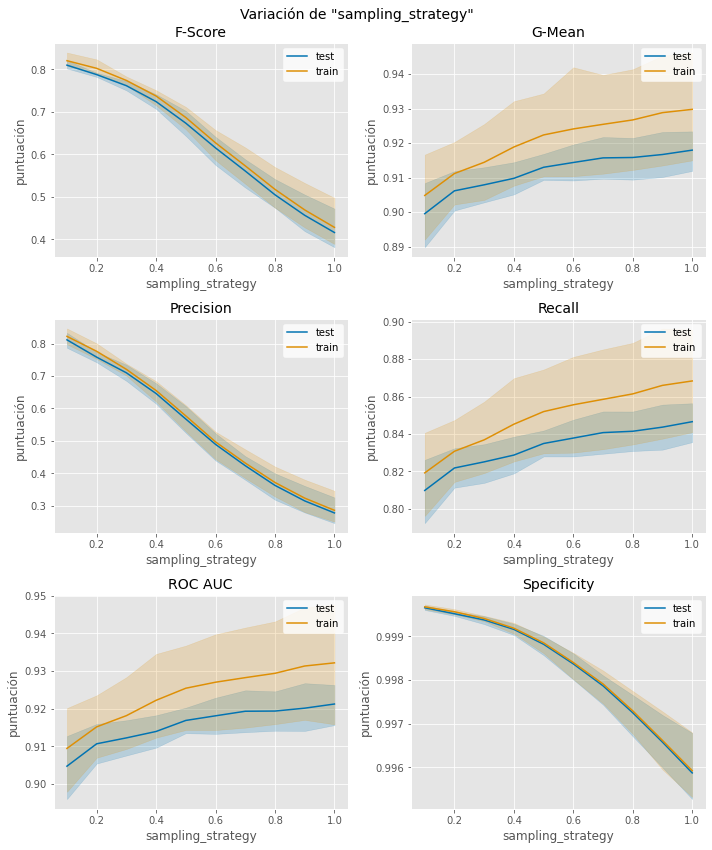

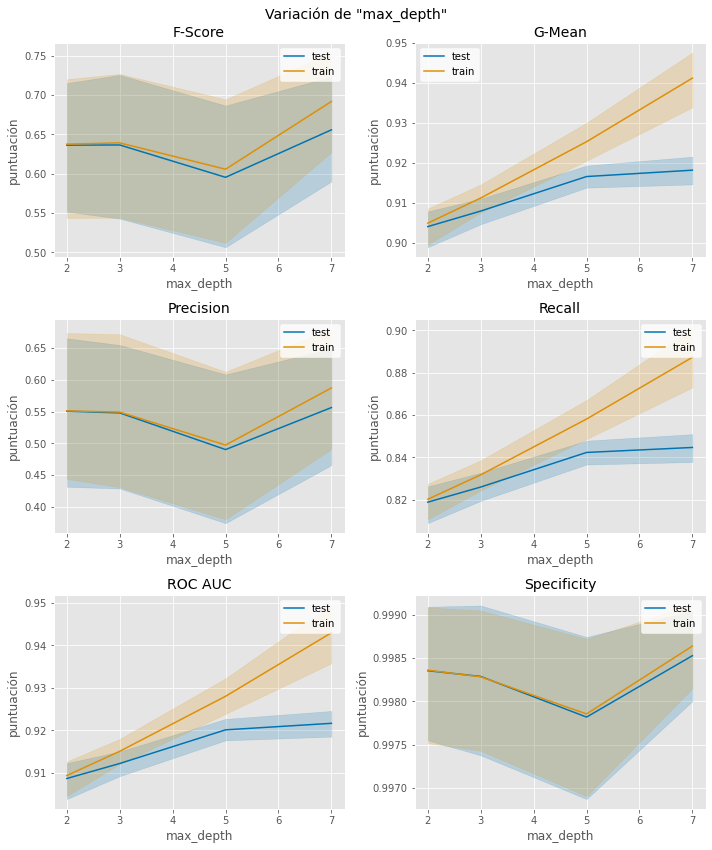

In [11]:
## SMOTE+RFC+GSCV
get_param_variation_by_exp_id(
    'SMOTE + RFC + GSCV', 'param_resampling__sampling_strategy')
get_param_variation_by_exp_id(
    'SMOTE + RFC + GSCV', 'param_estimator__max_depth')